# Homework 3 

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

Classification: forest
Classification: desert


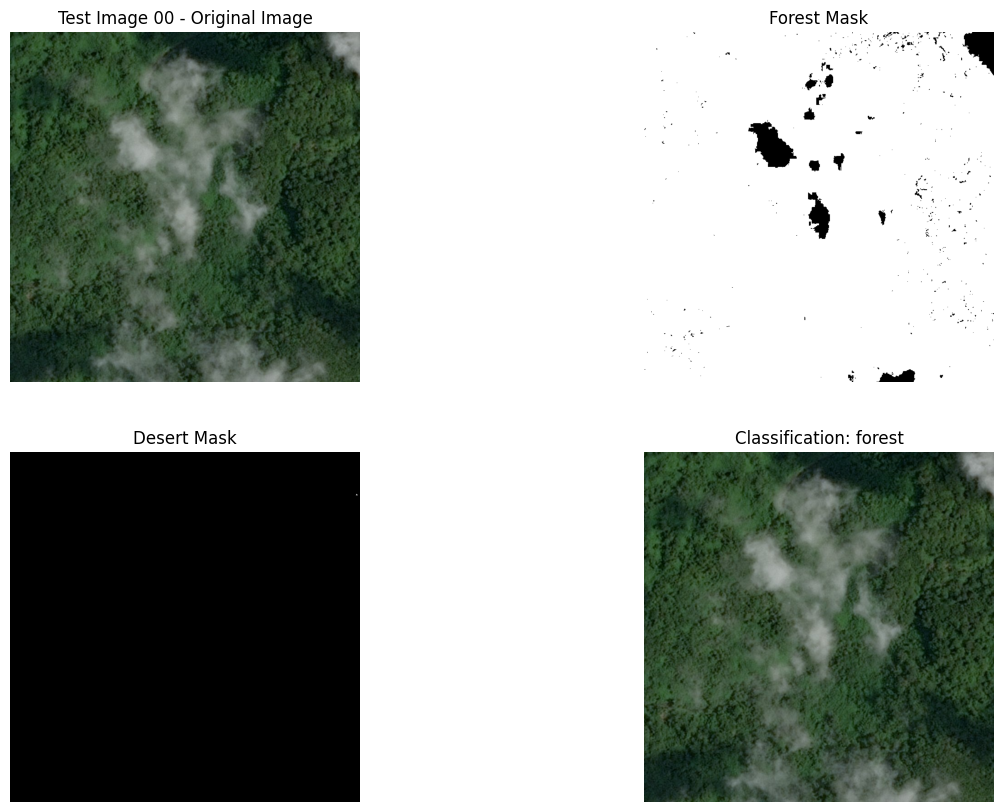

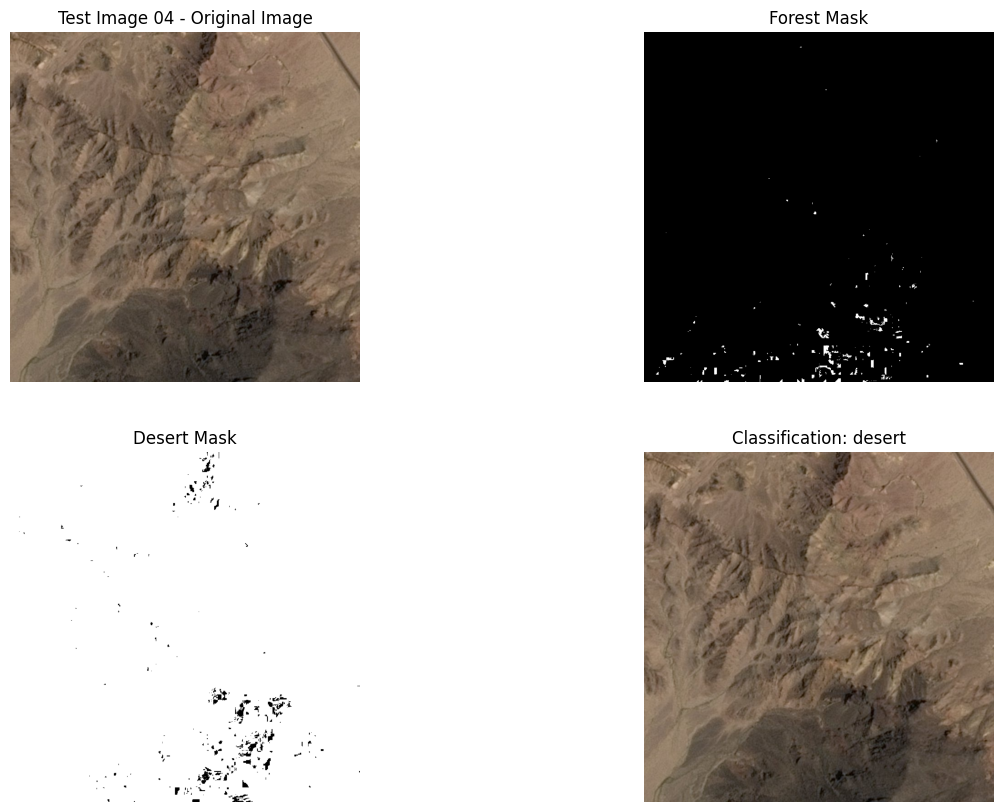

In [1]:
# Ваш код
import cv2
import numpy as np
import matplotlib.pyplot as plt

def classify_image(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # диапазоны для классов местонсти
    forest_masks = cv2.inRange(hsv_image, np.array([20, 20, 20]), np.array([100, 255, 255]))
    desert_masks = cv2.inRange(hsv_image, np.array([10, 20, 20]), np.array([30, 255, 255]))

    forest_count = cv2.countNonZero(forest_masks)
    desert_count = cv2.countNonZero(desert_masks)

    # классификация
    classification = "forest" if forest_count > desert_count else "desert"

    return classification, image, forest_masks, desert_masks

# тестовые изображения
images_path_forest = 'desert_forest/test_image_00.jpg'
classification_forest, image_forest, forest_mask_forest, desert_mask_forest = classify_image(images_path_forest)
print(f"Classification: {classification_forest}")

images_path_desert = 'desert_forest/test_image_04.jpg'
classification_desert, image_desert, forest_mask_desert, desert_mask_desert = classify_image(images_path_desert)
print(f"Classification: {classification_desert}")

# вывод изображений
def show_images(image, forest_mask, desert_mask, classification, title):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{title} - Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(forest_mask, cmap='gray')
    plt.title('Forest Mask')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(desert_mask, cmap='gray')
    plt.title('Desert Mask')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Classification: {classification}')
    plt.axis('off')

    plt.show()

show_images(image_forest, forest_mask_forest, desert_mask_forest, classification_forest, 'Test Image 00')
show_images(image_desert, forest_mask_desert, desert_mask_desert, classification_desert, 'Test Image 04')

# Задача №2 - Реализовать Image-blending на основе сшивки по градиентам

Задача - взять фото двух лиц : ваше и друга, с помощью метода Poisson image editing совместить глаза, нос и рот с первого изображения со вторым. Суть в том, что при использовании такого метода границы совмещенного изображения не видны.

Статья, где описан метод  

Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. https://doi.org/10.1145/882262.882269

Пример такого совмещения:

<img src="../homework/blending/blending.png" alt="Drawing" style="width: 700px;"/>


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Загружаем каскады Хаара для распознавания лиц и их частей
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
nose_cascade = cv2.CascadeClassifier('haar/haarcascade_mcs_nose.xml')  
mouth_cascade = cv2.CascadeClassifier('haar/haarcascade_mcs_mouth.xml')  

# Проверка корректности загрузки каскадов
if any(cascade.empty() for cascade in [face_cascade, eye_cascade, nose_cascade, mouth_cascade]):
    raise ValueError("Проблема с загрузкой хотя бы одного из каскадов Хаара. Проверьте пути.")

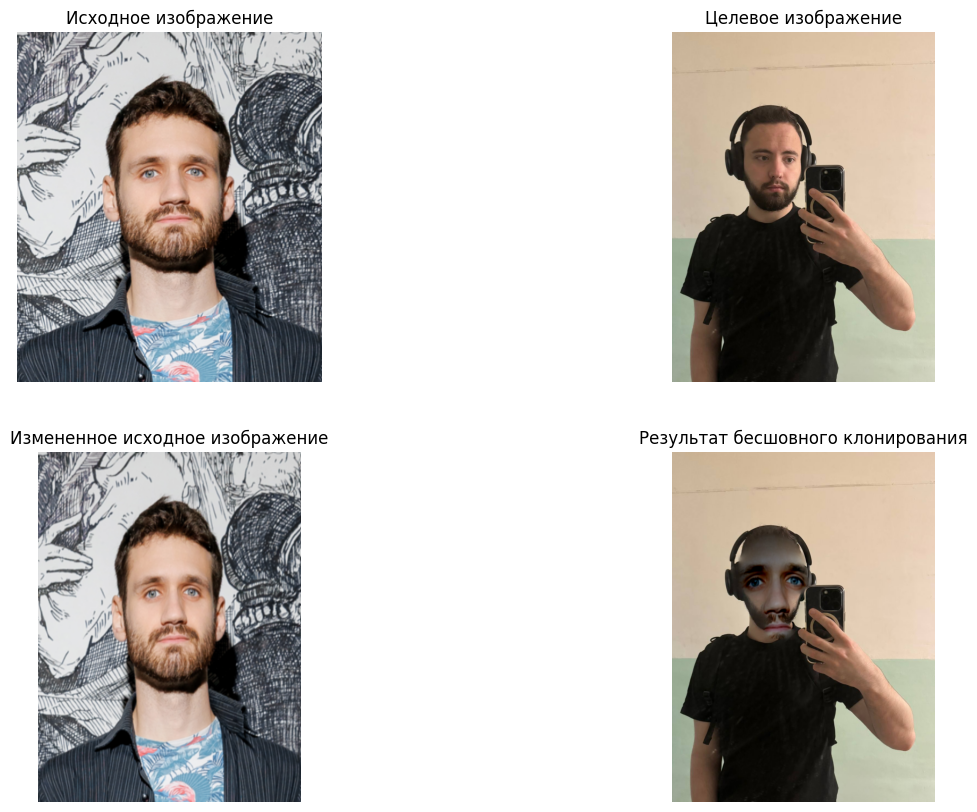

True

In [8]:
def detect_face_features(image_path):
    # Чтение изображения
    img = cv2.imread(image_path)

    # Проверка корректности загрузки изображения
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение по указанному пути: {image_path}")

    # Преобразование в оттенки серого
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Обнаружение лиц
    detected_faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.3, minNeighbors=5)

    # Создание маски для выделенных частей лица
    face_mask = np.zeros_like(gray_image)
    for (x, y, w, h) in detected_faces:
        roi_gray = gray_image[y:y+h, x:x+w]
        # roi_color = img[y:y+h, x:x+w]

        # Глаза
        detected_eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in detected_eyes:
            cv2.ellipse(face_mask, ((ex + ew//2 + x), (ey + eh//2 + y)), (ew//2, eh//2), 0, 0, 360, 255, -1)

        # Нос
        detected_nose = nose_cascade.detectMultiScale(roi_gray)
        for (nx, ny, nw, nh) in detected_nose:
            cv2.ellipse(face_mask, ((nx + nw//2 + x), (ny + nh//2 + y)), (nw//2, nh//2), 0, 0, 360, 255, -1)
        
        # Рот
        detected_mouth = mouth_cascade.detectMultiScale(roi_gray)
        for (mx, my, mw, mh) in detected_mouth:
            cv2.ellipse(face_mask, ((mx + mw//2 + x), (my + mh//2 + y)), (mw//3, mh//3), 0, 0, 360, 255, -1)

    return img, face_mask

# Загрузка изображений
source_image, source_mask = detect_face_features("faces/face_1.png")
target_image, target_mask = detect_face_features("faces/face_2.jpg")

# Приведение изображений к одинаковому размеру
target_height = target_image.shape[0]
target_width = target_image.shape[1]
resized_source = cv2.resize(source_image, (target_width, target_height))
resized_source_mask = cv2.resize(source_mask, (target_width, target_height))

# Центр для применения метода seamless cloning
clone_center = (int(target_width / 2.6), int(target_height / 2.6))

# Применение метода бесшовного клонирования
final_image = cv2.seamlessClone(resized_source, target_image, resized_source_mask, clone_center, cv2.NORMAL_CLONE)

# Отображение результатов с использованием matplotlib
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
plt.title('Целевое изображение')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(resized_source, cv2.COLOR_BGR2RGB))
plt.title('Измененное исходное изображение')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.title('Результат бесшовного клонирования')
plt.axis('off')

plt.show()

# Сохранение результата
cv2.imwrite('seamless_cloned_image.jpg', final_image)


# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="../img/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

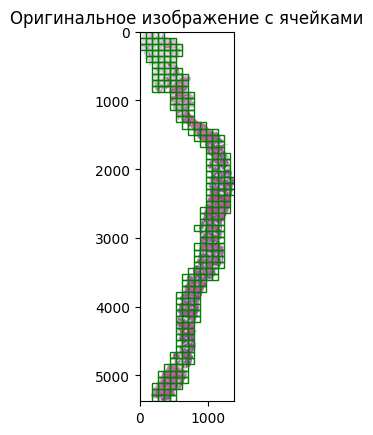

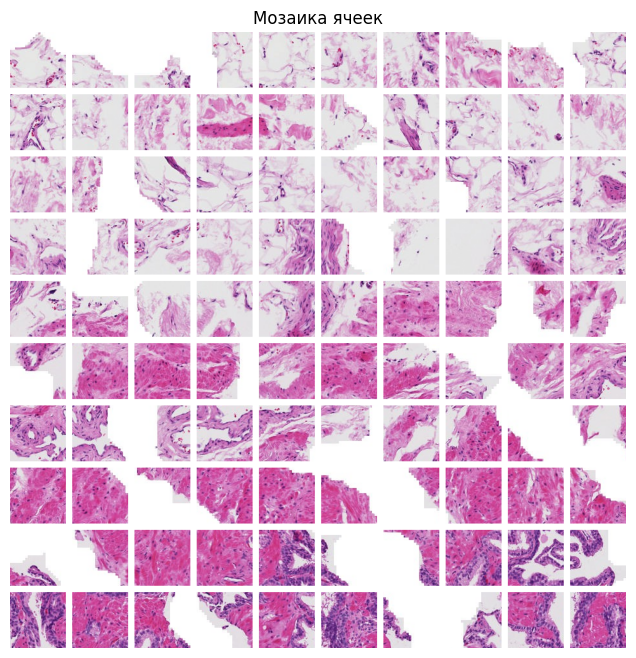

In [66]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches

def display_and_extract_cells(image_filepath, cell_dim, max_cells, space=10):
    img = Image.open(image_filepath)
    img_array = np.array(img)
    
    # Получаем размеры изображения
    height, width, _ = img_array.shape
    
    extracted_cells = []
    total_cells_extracted = 0
    fig, ax = plt.subplots(1)

    ax.imshow(img_array)
    
    # Проходим по изображению с шагом, равным размеру ячейки
    for y in range(0, height, cell_dim):
        for x in range(0, width, cell_dim):
            if total_cells_extracted >= max_cells:
                break
            
            # Извлечение ячейки
            cell = img_array[y:y + cell_dim, x:x + cell_dim]
            
            # Проверяем, содержит ли ячейка значимую информацию
            if cell.mean() < 240:  # Порог для фильтрации пустых участков
                extracted_cells.append(cell)
                total_cells_extracted += 1
                
                # Добавляем рамку на исходное изображение для визуализации
                rectangle = patches.Rectangle((x, y), cell_dim, cell_dim, linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(rectangle)

    plt.title("Оригинальное изображение с ячейками")
    plt.show()

    # Обработка количества ячеек для мозаики
    if len(extracted_cells) > 100:
        extracted_cells = extracted_cells[:100]
    elif len(extracted_cells) < 100:
        extracted_cells = extracted_cells * (100 // len(extracted_cells)) + extracted_cells[:100 % len(extracted_cells)]
    
    # Размер сетки и подготовка мозаики с учетом отступов
    grid_size = 10
    mosaic_dimensions = grid_size * cell_dim + (grid_size - 1) * space
    mosaic_image = np.ones((mosaic_dimensions, mosaic_dimensions, 3), dtype=np.uint8) * 255  # Белый фон

    for index, cell in enumerate(extracted_cells):
        row = index // grid_size
        col = index % grid_size
        y_start = row * (cell_dim + space)
        x_start = col * (cell_dim + space)
        mosaic_image[y_start:y_start + cell_dim, x_start:x_start + cell_dim] = cell

    plt.figure(figsize=(8, 8))
    plt.imshow(mosaic_image)
    plt.axis('off')
    plt.title("Мозаика ячеек")
    plt.show()

# Вызов функции с путь к изображению
display_and_extract_cells("cells/train3_1.jpeg", cell_dim=88, max_cells=267)